In [ ]:
from anaysis import analysis, add_to_usage, print_analysis, get_over_leaf_format


import sys
from matplotlib import pyplot as plt
import numpy as np
import json

def add_to_usage(usage_summary:dict, total_cost=0, total_prompt_tokens=0, total_completion_tokens=0):
    model = list(usage_summary.keys())[-1]
    total_prompt_tokens += usage_summary[model]['prompt_tokens']
    total_completion_tokens += usage_summary[model]['completion_tokens']
    return total_cost, total_prompt_tokens, total_completion_tokens    



def get_avg_accuracy_and_cost(log_path, file_folder, model_name, version="v1", round_cut=-1):
    d = 1_000_000  # price is per 1M tokens
    prices = {
        "gpt-4o": (2.5 / d, 10 / d),
        "gpt-4o-mini": (0.15 / d, 0.6 / d),
        "o1-mini": (1.1 / d, 4.4 / d),
        "o1": (15 / d, 7.5 / d),
        "o3-mini": (1.1 / d, 4.4 / d),
        "deepseek-r1": (0.55 / d, 0.27 / d),
        "phi4": (0.07/ d, 0.14/ d),
    }

    prompt_price, completion_price = prices[model_name]
    file_template = f"{log_path}/{file_folder}" + "/agent_incident_{0}.json"

    total_count = 0
    total_reward = 0
    total_prompt_tokens = 0
    total_completion_tokens = 0

    incidents = [5, 34, 38, 39, 55, 134, 166, 322]
    for i in incidents:
        with open(file_template.format(i), "r") as f:
            data = json.load(f)

        if version == "v2":
            result = analysis_v2(data)
        else:
            result = analysis(data)

        total_count += result['total_len']
        total_reward += result['total_reward']
        total_prompt_tokens += result['total_prompt_tokens']
        total_completion_tokens += result['total_completion_tokens']

    avg_accuracy = round(total_reward / total_count, 3)
    avg_cost = round(
        (total_prompt_tokens * prompt_price + total_completion_tokens * completion_price)
        / total_count,
        5,
    )

    return avg_accuracy, avg_cost

In [2]:
baselines = {
    "gpt-4o-mini": "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1",
    "gpt-4o": "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1",
    "o1-mini": ("BaselineAgent_o1-mini_c92_alert_level_t0_s25_trial1", "v2"),
    "o3-mini": ("BaselineAgent_o3-mini_c99_alert_level_t0_s25_trial1", "v2"),
    "phi4": ("BaselineAgent_phi4_c469_alert_level_t0_s25_trial1", "v2"),
    "deepseek-r1": ("BaselineAgent_r1_c468_alert_level_t0_s25_trial1", "v2"),
}

log_path = "../secgym/final_results"
results = {}

for name, b in baselines.items():
    if isinstance(b, tuple):
        file_folder, version = b
    else:
        file_folder = b
        version = "v1"

    avg_accuracy, avg_cost = get_avg_accuracy_and_cost(log_path, file_folder, name, version)
    results[name] = {
        "accuracy": avg_accuracy,
        "cost": avg_cost
    }

for k, v in results.items():
    print(f"{k}: accuracy = {v['accuracy']}, cost = {v['cost']}")

Error calculating usage: usage summar None
Error calculating usage: usage summar {}
gpt-4o-mini: accuracy = 0.192, cost = 0.00922
gpt-4o: accuracy = 0.293, cost = 0.23517
o1-mini: accuracy = 0.222, cost = 0.22425
o3-mini: accuracy = 0.296, cost = 0.1136
phi4: accuracy = 0.085, cost = 0.00746
deepseek-r1: accuracy = 0.084, cost = 0.00917


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_cost_vs_accuracy_seaborn(results, save_path=None):
    """
    Modified seaborn-style plot of cost vs accuracy, with Pareto front and improved layout.

    Args:
        results (dict): Dictionary with model names as keys and dicts of 'accuracy' and 'cost' as values.
        save_path (str, optional): Path to save the figure.
    """
    # Convert results into a DataFrame
    df = pd.DataFrame([
        {"Model": k, "Accuracy": v["accuracy"], "Cost": v["cost"]}
        for k, v in results.items()
    ])

    # Restore Seaborn whitegrid style
    sns.set(style="whitegrid", font_scale=1.2)
    palette = sns.color_palette("Set2", n_colors=len(df))
    markers = ['o', 's', 'D', '^', 'P', 'X', 'v', '<', '>']

    plt.figure(figsize=(8, 6))
    ax = sns.scatterplot(
        data=df,
        x="Cost", y="Accuracy",
        hue="Model", style="Model",
        palette=palette, markers=markers[:len(df)],
        s=120, edgecolor="black"
    )

    # Annotation offsets to avoid overlapping
    offset_map = {
        "gpt-4o-mini": (7, -1),
        "deepseek-r1": (6, -10),
        "phi4": (6, 8),
        "o3-mini": (6, 6),
        "gpt-4o": (-40, -2),
        "o1-mini": (6, -12),
    }
    for i, row in df.iterrows():
        dx, dy = offset_map.get(row["Model"], (5, 5))
        ax.annotate(
            row["Model"],
            (row["Cost"], row["Accuracy"]),
            textcoords="offset points",
            xytext=(dx, dy),
            fontsize=11,
            weight="bold"
        )

    # Pareto front (accuracy > 0.15)
    filtered = df[df["Accuracy"] > 0.15].sort_values(by=["Cost", "Accuracy"])
    pareto_front = [filtered.iloc[0]]
    for _, row in filtered.iterrows():
        if row["Accuracy"] > pareto_front[-1]["Accuracy"]:
            pareto_front.append(row)
    if len(pareto_front) > 1:
        pareto_df = pd.DataFrame(pareto_front)
        plt.plot(pareto_df["Cost"], pareto_df["Accuracy"], linestyle='--', color='black', label="Pareto Front")

    # Axis labels (larger font)
    plt.xlabel("Cost", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)

    # Legend inside plot
    plt.legend(loc='lower right', frameon=True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


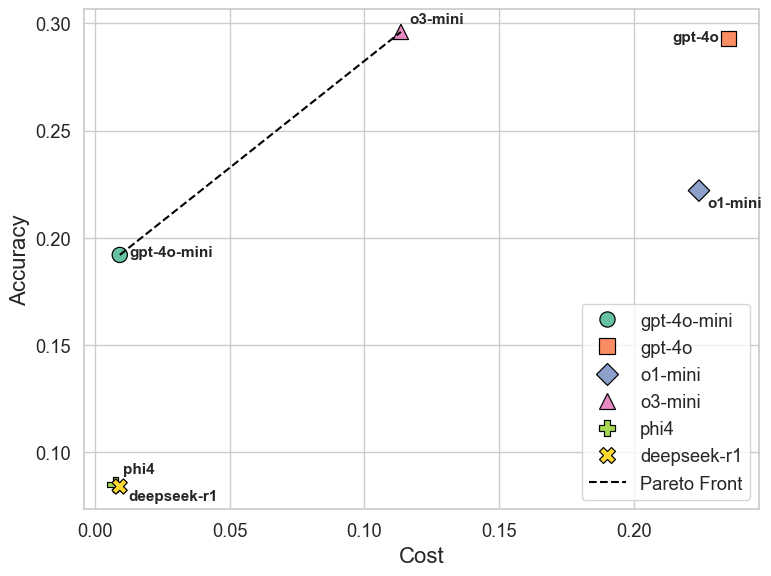

In [32]:
plot_cost_vs_accuracy_seaborn(results, save_path="cost_vs_accuracy.pdf")